In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import random

In [2]:
path = '../Dataset/Dataset.tsv'

# Read the dataset
df = pd.read_csv(path, sep='\t')

df.head()

,Study ID,Patient ID,Sample ID,Age in years,Absolute Neutrophil Count (G/L),BM Blast (%),Chromosomal Status at TP53,CNACS Called Chr Arm Gain,CNACS Called Chr Arm Loss,CNACS Called Chr Arm Upd,...,Overall Survival (Months),Overall Survival Status,PB Blast (%),Platelet (G/L),Ringed Sideroblast (%),Number of Samples Per Patient,Sex,TMB (nonsynonymous),White Blood Cell Count (G/L),WHO 2016 Classification
0,mds_iwg_2022,E-H-100000,E-H-100000-T1-1-D1-1,57.0,4.65,3.0,normal,NaN,5q,NaN,...,69.830137,0:LIVING,0.0,406.0,NaN,1,Female,23.920896,7.50,MDS-del5q
1,mds_iwg_2022,E-H-100001,E-H-100001-T1-1-D1-1,56.0,2.88,2.0,normal,NaN,5q,NaN,...,34.290411,0:LIVING,0.0,364.0,NaN,1,Female,6.523881,7.21,MDS-del5q
2,mds_iwg_2022,E-H-100002,E-H-100002-T1-1-D1-1,72.0,0.49,15.0,cnloh,NaN,5q,17p,...,3.682192,1:DECEASED,0.0,35.0,NaN,1,Female,6.523881,2.60,MDS-EB2
3,mds_iwg_2022,E-H-100004,E-H-100004-T1-1-D1-1,40.0,1.56,3.0,normal,NaN,NaN,NaN,...,62.235616,0:LIVING,0.0,708.0,NaN,1,Female,4.349254,2.55,MDS/MPN-U
4,mds_iwg_2022,E-H-100005,E-H-100005-T1-1-D1-1,45.0,1.25,2.0,normal,NaN,NaN,NaN,...,67.758904,0:LIVING,0.0,141.0,NaN,1,Female,6.523881,2.31,MDS-MLD


In [3]:
variables_IPSSR = ['BM Blast (%)', 'Hemoglobin (g/dL)', 'Platelet (G/L)', 'Absolute Neutrophil Count (G/L)', 'IPSS-R Cytogenetic Category', 'Patient ID']

# Create a new dataframe with only the variables of interest
df_IPSSR = df[variables_IPSSR]

df_IPSSR.dropna()

df_IPSSR


,BM Blast (%),Hemoglobin (g/dL),Platelet (G/L),Absolute Neutrophil Count (G/L),IPSS-R Cytogenetic Category,Patient ID
0,3.0,8.8,406.0,4.65,Good,E-H-100000
1,2.0,9.8,364.0,2.88,Good,E-H-100001
2,15.0,8.9,35.0,0.49,Very-Poor,E-H-100002
3,3.0,7.0,708.0,1.56,Good,E-H-100004
4,2.0,11.8,141.0,1.25,Good,E-H-100005
...,...,...,...,...,...,...
3318,12.0,11.5,61.0,0.60,Good,I-H-132725
3319,15.0,11.2,383.0,0.50,Good,I-H-132726
3320,5.0,11.3,44.0,1.00,Good,I-H-132727
3321,2.0,8.2,14.0,40.10,Int,I-H-132728


In [4]:
list_dp_columns = ['DP BM Blast (%)', 'DP Hemoglobin (g/dL)', 'DP Platelet (G/L)', 'DP Absolute Neutrophil Count (G/L)', 'DP IPSS-R Cytogenetic Category', 'Patient ID']

df_IPSSR_dp = pd.DataFrame(columns=list_dp_columns)

df_IPSSR_dp


,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID


In [5]:
# copute min max for each column
min_max = {}
for column in variables_IPSSR:
    if column != 'IPSS-R Cytogenetic Category' and column != 'Patient ID':
        min_max[column] = [df_IPSSR[column].min(), df_IPSSR[column].max()]

print(min_max)


{'BM Blast (%)': [0.0, 91.0], 'Hemoglobin (g/dL)': [3.1, 16.6], 'Platelet (G/L)': [2.0, 1451.0], 'Absolute Neutrophil Count (G/L)': [0.0, 109.62]}


## Local DP

In [6]:
from diffprivlib.mechanisms import LaplaceTruncated

epsilon_1 = 0.1
epsilon_2 = 1
epsilon_3 = 5

In [7]:
#create a list of the values of the column 'BM Blast (%)'
values = df_IPSSR['BM Blast (%)'].tolist()

#add noise to the values
def add_noise(values):
    dp_values = []
    for value in values:
        mech = LaplaceTruncated(epsilon = epsilon_3, sensitivity = 1, lower = 0, upper = 91)
        dp_value = mech.randomise(value)
        if dp_value < 0:
            dp_value = 0
        dp_values.append(dp_value)
    return dp_values

dp_values = add_noise(values)

df_IPSSR_dp['DP BM Blast (%)'] = dp_values

df_IPSSR_dp


,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID
0,2.995565,NaN,NaN,NaN,NaN,NaN
1,2.003509,NaN,NaN,NaN,NaN,NaN
2,15.103674,NaN,NaN,NaN,NaN,NaN
3,2.651916,NaN,NaN,NaN,NaN,NaN
4,2.211202,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3318,12.236912,NaN,NaN,NaN,NaN,NaN
3319,15.009998,NaN,NaN,NaN,NaN,NaN
3320,5.163020,NaN,NaN,NaN,NaN,NaN
3321,2.064695,NaN,NaN,NaN,NaN,NaN


In [8]:
#create a list of the values of the column 'Hemoglobin (g/dL)'
values = df_IPSSR['Hemoglobin (g/dL)'].tolist()

#add noise to the values
def add_noise(values):
    dp_values = []
    for value in values:
        mech = LaplaceTruncated(epsilon = epsilon_3, sensitivity=  1, lower = 3.1, upper = 16.6)
        dp_value = mech.randomise(value)
        if dp_value < 0:
            dp_value = 0
        dp_values.append(dp_value)
    return dp_values

dp_values = add_noise(values)

df_IPSSR_dp['DP Hemoglobin (g/dL)'] = dp_values

df_IPSSR_dp


,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID
0,2.995565,8.859814,NaN,NaN,NaN,NaN
1,2.003509,9.666358,NaN,NaN,NaN,NaN
2,15.103674,9.182862,NaN,NaN,NaN,NaN
3,2.651916,7.382284,NaN,NaN,NaN,NaN
4,2.211202,11.596359,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3318,12.236912,11.563692,NaN,NaN,NaN,NaN
3319,15.009998,11.214598,NaN,NaN,NaN,NaN
3320,5.163020,10.950607,NaN,NaN,NaN,NaN
3321,2.064695,8.221313,NaN,NaN,NaN,NaN


In [9]:
#create a list of the values of the column 'Platelet (G/L)'
values = df_IPSSR['Platelet (G/L)'].tolist()

#add noise to the values
def add_noise(values):
    dp_values = []
    for value in values:
        mech = LaplaceTruncated(epsilon = epsilon_3, sensitivity = 1, lower = 2.0, upper = 1451.0)
        dp_value = mech.randomise(value)
        if dp_value < 0:
            dp_value = 0
        dp_values.append(dp_value)
    return dp_values

dp_values = add_noise(values)

df_IPSSR_dp['DP Platelet (G/L)'] = dp_values

df_IPSSR_dp


,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID
0,2.995565,8.859814,406.513389,NaN,NaN,NaN
1,2.003509,9.666358,363.993873,NaN,NaN,NaN
2,15.103674,9.182862,35.425750,NaN,NaN,NaN
3,2.651916,7.382284,708.017738,NaN,NaN,NaN
4,2.211202,11.596359,140.814630,NaN,NaN,NaN
...,...,...,...,...,...,...
3318,12.236912,11.563692,60.956125,NaN,NaN,NaN
3319,15.009998,11.214598,382.589511,NaN,NaN,NaN
3320,5.163020,10.950607,44.205662,NaN,NaN,NaN
3321,2.064695,8.221313,14.230847,NaN,NaN,NaN


In [10]:
#create a list of the values of the column 'Absolute Neutrophil Count (G/L)'
values = df_IPSSR['Absolute Neutrophil Count (G/L)'].tolist()

#add noise to the values
def add_noise(values):
    dp_values = []
    for value in values:
        mech = LaplaceTruncated(epsilon = epsilon_3, sensitivity = 1, lower = 0.0, upper = 109.62)
        dp_value = mech.randomise(value)
        if dp_value < 0:
            dp_value = 0
        dp_values.append(dp_value)
    return dp_values

dp_values = add_noise(values)

df_IPSSR_dp['DP Absolute Neutrophil Count (G/L)'] = dp_values

df_IPSSR_dp


,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID
0,2.995565,8.859814,406.513389,4.655837,NaN,NaN
1,2.003509,9.666358,363.993873,4.179576,NaN,NaN
2,15.103674,9.182862,35.425750,0.544990,NaN,NaN
3,2.651916,7.382284,708.017738,2.072498,NaN,NaN
4,2.211202,11.596359,140.814630,1.429350,NaN,NaN
...,...,...,...,...,...,...
3318,12.236912,11.563692,60.956125,0.000000,NaN,NaN
3319,15.009998,11.214598,382.589511,0.729277,NaN,NaN
3320,5.163020,10.950607,44.205662,0.831316,NaN,NaN
3321,2.064695,8.221313,14.230847,39.741470,NaN,NaN


In [11]:
# copy the column 'IPSS-R Cytogenetic Category' from df_IPSSR to df_IPSSR_dp
df_IPSSR_dp['DP IPSS-R Cytogenetic Category'] = df_IPSSR['IPSS-R Cytogenetic Category']

df_IPSSR_dp

,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID
0,2.995565,8.859814,406.513389,4.655837,Good,NaN
1,2.003509,9.666358,363.993873,4.179576,Good,NaN
2,15.103674,9.182862,35.425750,0.544990,Very-Poor,NaN
3,2.651916,7.382284,708.017738,2.072498,Good,NaN
4,2.211202,11.596359,140.814630,1.429350,Good,NaN
...,...,...,...,...,...,...
3318,12.236912,11.563692,60.956125,0.000000,Good,NaN
3319,15.009998,11.214598,382.589511,0.729277,Good,NaN
3320,5.163020,10.950607,44.205662,0.831316,Good,NaN
3321,2.064695,8.221313,14.230847,39.741470,Int,NaN


In [12]:
# copy the column 'Patient ID' from df_IPSSR to df_IPSSR_dp
df_IPSSR_dp['Patient ID'] = df_IPSSR['Patient ID']

df_IPSSR_dp

,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID
0,2.995565,8.859814,406.513389,4.655837,Good,E-H-100000
1,2.003509,9.666358,363.993873,4.179576,Good,E-H-100001
2,15.103674,9.182862,35.425750,0.544990,Very-Poor,E-H-100002
3,2.651916,7.382284,708.017738,2.072498,Good,E-H-100004
4,2.211202,11.596359,140.814630,1.429350,Good,E-H-100005
...,...,...,...,...,...,...
3318,12.236912,11.563692,60.956125,0.000000,Good,I-H-132725
3319,15.009998,11.214598,382.589511,0.729277,Good,I-H-132726
3320,5.163020,10.950607,44.205662,0.831316,Good,I-H-132727
3321,2.064695,8.221313,14.230847,39.741470,Int,I-H-132728


## DP IPSS-R Score and new Categories

In [13]:
# BM Blast (%) points
def compute_BM_points(column):
    points = []
    for value in column:
        if value <= 2:
            points.append(0)
        elif 2 < value < 5:
            points.append(1)
        elif 5 <= value <= 10:
            points.append(2)
        else:
            points.append(3)
    return points

BM_points_dp = compute_BM_points(df_IPSSR_dp['DP BM Blast (%)'])
print(BM_points_dp)

[1, 1, 3, 1, 1, 0, 0, 0, 2, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 2, 3, 2, 0, 0, 3, 3, 1, 0, 2, 3, 2, 2, 2, 3, 1, 1, 0, 0, 0, 0, 3, 1, 3, 2, 0, 3, 3, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 1, 0, 3, 0, 1, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 3, 3, 0, 2, 0, 2, 0, 3, 0, 3, 2, 0, 0, 1, 3, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 3, 1, 1, 0, 1, 2, 0, 0, 1, 3, 0, 1, 0, 1, 0, 1, 3, 0, 3, 2, 1, 2, 2, 1, 1, 1, 3, 1, 2, 3, 0, 3, 2, 1, 3, 1, 0, 0, 3, 1, 1, 0, 1, 3, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 1, 3, 0, 2, 2, 1, 0, 1, 1, 3, 1, 3, 1, 0, 3, 3, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 3, 0, 0, 3, 3, 1, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 3, 0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 1, 0, 1, 1, 1, 3, 0, 3, 2, 3, 3, 3, 2, 3, 0, 2, 1, 3, 3, 2, 3, 3, 3, 0, 3, 2, 3, 2, 3, 1, 3, 1, 1, 0, 0, 2, 0, 0, 2, 3, 0, 2, 0, 3, 2, 3, 0, 3, 3, 2, 1, 3, 3, 3, 1, 1, 3, 2, 1, 2, 0, 1, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 1, 3, 0, 1, 0, 1, 1, 0, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 3, 2, 1, 1, 3, 3, 3, 0, 3, 1, 1, 0, 3, 3, 0, 1, 1, 0, 

In [14]:
# Hemoglobin (g/dL) points
def compute_Hemog_points(column):
    points = []
    for value in column:
        if value >= 10:
            points.append(0)
        elif 8 <= value < 10:
            points.append(1)
        else:
            points.append(1.5)
    return points

Hemog_points_dp = compute_Hemog_points(df_IPSSR_dp['DP Hemoglobin (g/dL)'])
print(Hemog_points_dp)

[1, 1, 1, 1.5, 0, 1.5, 1, 0, 1.5, 1, 1, 0, 0, 1.5, 0, 1.5, 1, 1, 1, 0, 0, 0, 1, 1, 1.5, 1, 0, 0, 1, 1, 1, 0, 1.5, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1.5, 1.5, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1.5, 1, 0, 0, 0, 0, 0, 1.5, 0, 1.5, 0, 1, 0, 1.5, 0, 1, 0, 0, 0, 0, 0, 0, 1.5, 1, 1, 0, 1, 1, 1, 0, 0, 1.5, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1.5, 1, 0, 1, 1.5, 0, 1, 0, 1, 0, 1, 0, 1.5, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1.5, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1.5, 0, 0, 1.5, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1.5, 1, 0, 1.5, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1.5, 1.5, 0, 1.5, 0, 0, 1, 1.5, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1.5, 0, 1, 0, 1, 0, 1, 0, 1.5, 1.5, 1, 1, 1, 0, 1, 1.5, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1.5, 1, 0, 1, 0, 1.5, 1, 0, 1, 1, 1.5, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1.5, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1.5, 1.5, 0, 1.5, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1.5, 1, 0, 0, 1, 0, 

In [15]:
# Platelet (G/L) points
def compute_Platelet_points(column):
    points = []
    for value in column:
        if value >= 100:
            points.append(0)
        elif 50 <= value < 100:
            points.append(0.5)
        else:
            points.append(1)
    return points

Platelet_points_dp = compute_Platelet_points(df_IPSSR_dp['DP Platelet (G/L)'])
print(Platelet_points_dp)

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0.5, 0.5, 0, 1, 0.5, 0, 0.5, 1, 0.5, 1, 1, 0, 0, 0, 0, 0.5, 0, 0, 0, 0.5, 1, 0, 0, 0, 0, 0, 1, 0, 0.5, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 1, 0, 1, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0.5, 0, 0, 0.5, 0, 0.5, 0, 0, 1, 0, 0.5, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 1, 0, 0, 1, 0.5, 0, 1, 0, 0, 1, 0.5, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0.5, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 1, 0.5, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 1, 0, 0, 0.5, 0, 0.5, 0.5, 1, 0, 0, 0.5, 0, 0, 0, 1, 1, 0, 0, 0.5, 0, 0.5, 0, 1, 0.5, 0.5, 0.5, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.5, 1, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 1, 0, 0.5, 0, 0.5, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0.5, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 1, 1, 0.5, 0, 0.5, 0, 0.5, 0, 0, 0, 0.5, 0, 0, 0.5, 1, 0.5, 1, 0, 0.5, 0, 1, 0.5, 1, 0, 0, 0.5, 0, 0, 0, 0, 0.5, 0, 0.5, 1, 0, 0, 0, 1, 0.5, 1, 0.5, 0

In [16]:
# Absolute Neutrophil Count (G/L) points
def compute_ANC_points(column):
    points = []
    for value in column:
        if value >= 0.8:
            points.append(0)
        else:
            points.append(0.5)
    return points

ANC_points_dp = compute_ANC_points(df_IPSSR_dp['DP Absolute Neutrophil Count (G/L)'])
print(ANC_points_dp)

[0, 0, 0.5, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0.5, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0.5, 0, 0, 0.5, 0.5, 0, 0, 0.5, 0, 0, 0, 0.5, 0, 0, 0.5, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0.5, 0, 0, 0, 0.5, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0.5, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5, 0, 0, 0.5, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0.5, 0.5, 0, 0.5, 0, 0.5, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
# Cytogenetic Category points
def compute_cytogenetics_points(column):
    points = []
    for value in column:
        if value == 'Very-Good':
            points.append(0)
        elif value == 'Good':
            points.append(1)
        elif value == 'Int':
            points.append(2)
        elif value == 'Poor':
            points.append(3)
        else:
            points.append(4)
    return points

cytogenetics_points_dp = compute_cytogenetics_points(df_IPSSR_dp['DP IPSS-R Cytogenetic Category'])
print(cytogenetics_points_dp)

[1, 1, 4, 1, 1, 4, 1, 1, 0, 4, 1, 1, 1, 4, 4, 2, 2, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 4, 1, 2, 1, 1, 1, 1, 4, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 4, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 3, 4, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 2, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 2, 1, 1, 1, 1, 4, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 4, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 0, 1, 4, 1, 1, 2, 1, 4, 2, 1, 2, 3, 1, 1, 1, 1, 4, 4, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 3, 1, 1, 1, 1, 

In [18]:
def risk_IPSSR(array1, array2, array3, array4, array5):
    res = []
    sums = []
    for value1, value2, value3, value4, value5 in zip(array1, array2, array3, array4, array5):
        sums.append(value1 + value2 + value3 + value4 + value5)
    for sum in sums:
        if sum <= 1.5:
            res.append('Very Low')
        elif 1.5 < sum <= 3:
            res.append('Low')
        elif 3 < sum <= 4.5:
            res.append('Intermediate')
        elif 4.5 < sum <= 6:
            res.append('High')
        elif sum > 6:
            res.append('Very High')
    return res

risk_IPSSR_dp = risk_IPSSR(BM_points_dp, Hemog_points_dp, Platelet_points_dp, ANC_points_dp, cytogenetics_points_dp)
print(risk_IPSSR_dp)

['Low', 'Low', 'Very High', 'Intermediate', 'Low', 'High', 'Low', 'Very Low', 'High', 'Very High', 'Low', 'Very Low', 'Intermediate', 'Very High', 'Intermediate', 'Very High', 'Very High', 'Very High', 'High', 'Intermediate', 'Intermediate', 'Intermediate', 'Low', 'Low', 'Very High', 'High', 'Low', 'Very Low', 'Intermediate', 'High', 'Very High', 'Intermediate', 'Intermediate', 'Very High', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very High', 'Low', 'Very High', 'High', 'Low', 'High', 'High', 'Very Low', 'Very Low', 'Intermediate', 'High', 'Very Low', 'High', 'High', 'Very Low', 'Low', 'Very Low', 'Low', 'Very Low', 'Intermediate', 'Very Low', 'Low', 'Very High', 'Very Low', 'Very High', 'Very Low', 'Low', 'Low', 'Intermediate', 'Very Low', 'Low', 'Very Low', 'Low', 'Low', 'High', 'Intermediate', 'Very Low', 'High', 'Intermediate', 'High', 'Very Low', 'Very High', 'High', 'High', 'Intermediate', 'Very Low', 'Intermediate', 'High', 'High', 'Low', 'Very Low', 'Low',

## Survival Analysis

In [19]:
path_verylow = '../Dataset/csv_Survival_Analysis/VeryLow.csv'
df_verylow = pd.read_csv(path_verylow, sep='\t')
path_low = '../Dataset/csv_Survival_Analysis/Low.csv'
df_low = pd.read_csv(path_low, sep='\t')
path_int = '../Dataset/csv_Survival_Analysis/Int.csv'
df_int = pd.read_csv(path_int, sep='\t')
path_high = '../Dataset/csv_Survival_Analysis/High.csv'
df_high = pd.read_csv(path_high, sep='\t')
path_veryhigh = '../Dataset/csv_Survival_Analysis/VeryHigh.csv'
df_veryhigh = pd.read_csv(path_veryhigh, sep='\t')

df_verylow

,Case ID,Number at Risk,Status,Survival Rate,Time (months)
0,E-H-117419,482,censored,1.000000,0.000000
1,E-H-105850,481,censored,1.000000,0.000000
2,E-H-105880,480,censored,1.000000,0.000000
3,E-H-110409,479,censored,1.000000,0.000000
4,E-H-110822,478,censored,1.000000,0.000000
...,...,...,...,...,...
477,E-H-116729,5,censored,0.329087,174.641096
478,E-H-105459,4,censored,0.329087,176.975343
479,E-H-105982,3,censored,0.329087,184.701370
480,E-H-105515,2,deceased,0.164543,191.276712


In [20]:
import kaplanmeier as km

# Add a column with the risk group to each of the dataframes
df_verylow['Risk Group'] = 'Very Low'
df_low['Risk Group'] = 'Low'
df_int['Risk Group'] = 'Intermediate'
df_high['Risk Group'] = 'High'
df_veryhigh['Risk Group'] = 'Very High'

# Concatenate the dataframes
df_survival = pd.concat([df_verylow, df_low, df_int, df_high, df_veryhigh])

df_survival

,Case ID,Number at Risk,Status,Survival Rate,Time (months),Risk Group
0,E-H-117419,482,censored,1.000000,0.000000,Very Low
1,E-H-105850,481,censored,1.000000,0.000000,Very Low
2,E-H-105880,480,censored,1.000000,0.000000,Very Low
3,E-H-110409,479,censored,1.000000,0.000000,Very Low
4,E-H-110822,478,censored,1.000000,0.000000,Very Low
...,...,...,...,...,...,...
355,E-H-105678,5,censored,0.058110,77.786301,Very High
356,E-H-116517,4,deceased,0.043582,79.923288,Very High
357,E-H-105691,3,censored,0.043582,97.380822,Very High
358,E-H-105650,2,censored,0.043582,129.665753,Very High


In [21]:
# map censored values to 0 and decesead values to 1
df_survival['Status'] = df_survival['Status'].map({'censored': 0, 'deceased': 1})

df_survival

,Case ID,Number at Risk,Status,Survival Rate,Time (months),Risk Group
0,E-H-117419,482,0,1.000000,0.000000,Very Low
1,E-H-105850,481,0,1.000000,0.000000,Very Low
2,E-H-105880,480,0,1.000000,0.000000,Very Low
3,E-H-110409,479,0,1.000000,0.000000,Very Low
4,E-H-110822,478,0,1.000000,0.000000,Very Low
...,...,...,...,...,...,...
355,E-H-105678,5,0,0.058110,77.786301,Very High
356,E-H-116517,4,1,0.043582,79.923288,Very High
357,E-H-105691,3,0,0.043582,97.380822,Very High
358,E-H-105650,2,0,0.043582,129.665753,Very High


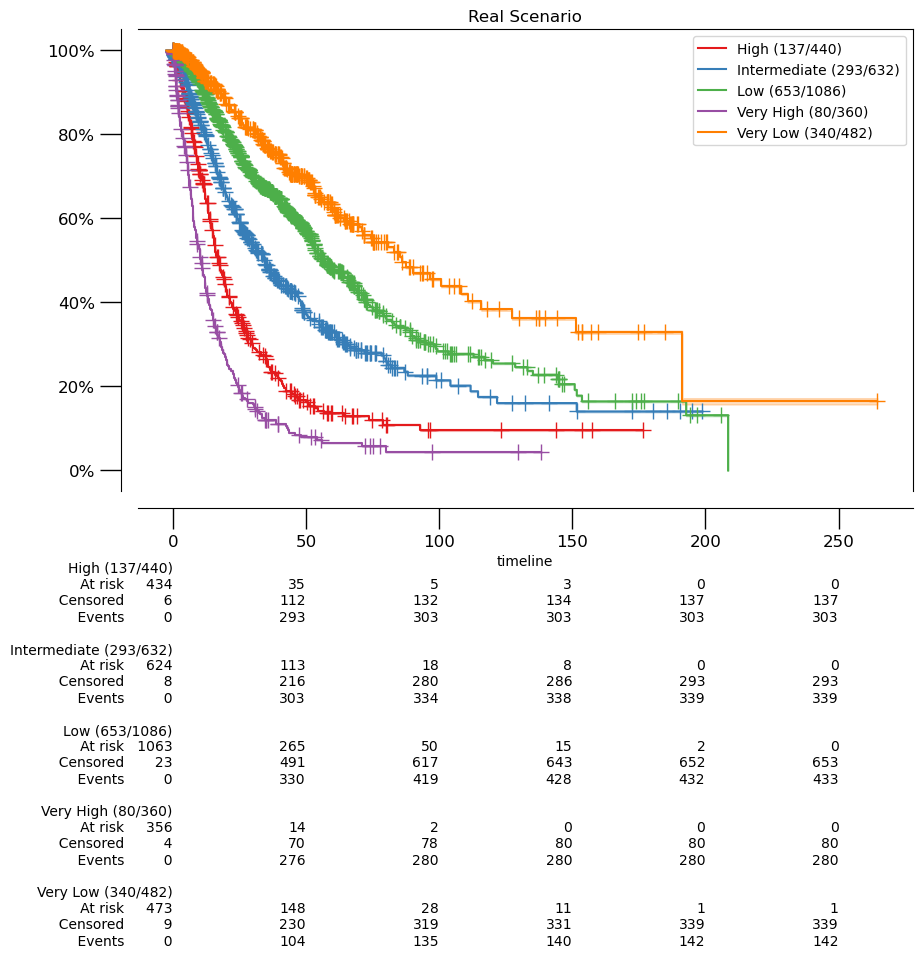

In [22]:
time_real_event = df_survival['Time (months)']
censoring_real_event = df_survival['Status']
y = df_survival['Risk Group']

# compute survival
km_real_scenario = km.fit(time_real_event, censoring_real_event, y)

# plot survival
km.plot(km_real_scenario, title='Real Scenario', y_percentage=True, width=10, height=6)


## DP Survival Analysis

In [23]:
df_IPSSR_dp

,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID
0,2.995565,8.859814,406.513389,4.655837,Good,E-H-100000
1,2.003509,9.666358,363.993873,4.179576,Good,E-H-100001
2,15.103674,9.182862,35.425750,0.544990,Very-Poor,E-H-100002
3,2.651916,7.382284,708.017738,2.072498,Good,E-H-100004
4,2.211202,11.596359,140.814630,1.429350,Good,E-H-100005
...,...,...,...,...,...,...
3318,12.236912,11.563692,60.956125,0.000000,Good,I-H-132725
3319,15.009998,11.214598,382.589511,0.729277,Good,I-H-132726
3320,5.163020,10.950607,44.205662,0.831316,Good,I-H-132727
3321,2.064695,8.221313,14.230847,39.741470,Int,I-H-132728


In [24]:
df_survival

,Case ID,Number at Risk,Status,Survival Rate,Time (months),Risk Group
0,E-H-117419,482,0,1.000000,0.000000,Very Low
1,E-H-105850,481,0,1.000000,0.000000,Very Low
2,E-H-105880,480,0,1.000000,0.000000,Very Low
3,E-H-110409,479,0,1.000000,0.000000,Very Low
4,E-H-110822,478,0,1.000000,0.000000,Very Low
...,...,...,...,...,...,...
355,E-H-105678,5,0,0.058110,77.786301,Very High
356,E-H-116517,4,1,0.043582,79.923288,Very High
357,E-H-105691,3,0,0.043582,97.380822,Very High
358,E-H-105650,2,0,0.043582,129.665753,Very High


In [25]:
# add a column with times and statuses to df_IPSSR_dp full of 0s
df_IPSSR_dp['Time (months)'] = np.nan
df_IPSSR_dp['Status'] = np.nan

df_IPSSR_dp

,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID,Time (months),Status
0,2.995565,8.859814,406.513389,4.655837,Good,E-H-100000,NaN,NaN
1,2.003509,9.666358,363.993873,4.179576,Good,E-H-100001,NaN,NaN
2,15.103674,9.182862,35.425750,0.544990,Very-Poor,E-H-100002,NaN,NaN
3,2.651916,7.382284,708.017738,2.072498,Good,E-H-100004,NaN,NaN
4,2.211202,11.596359,140.814630,1.429350,Good,E-H-100005,NaN,NaN
...,...,...,...,...,...,...,...,...
3318,12.236912,11.563692,60.956125,0.000000,Good,I-H-132725,NaN,NaN
3319,15.009998,11.214598,382.589511,0.729277,Good,I-H-132726,NaN,NaN
3320,5.163020,10.950607,44.205662,0.831316,Good,I-H-132727,NaN,NaN
3321,2.064695,8.221313,14.230847,39.741470,Int,I-H-132728,NaN,NaN


In [26]:
# Create a dictionary to map Case ID to Time and Status
survival_info = {}
for index, row in df_survival.iterrows():
    case_id = row['Case ID']
    survival_info[case_id] = {
        'Time (months)': row['Time (months)'],
        'Status': row['Status']
    }

# Update df_IPSSR_dp using the survival_info dictionary
for index, row in df_IPSSR_dp.iterrows():
    case_id = row['Patient ID']
    if case_id in survival_info:
        df_IPSSR_dp.at[index, 'Time (months)'] = survival_info[case_id]['Time (months)']
        df_IPSSR_dp.at[index, 'Status'] = survival_info[case_id]['Status']

df_IPSSR_dp

,DP BM Blast (%),DP Hemoglobin (g/dL),DP Platelet (G/L),DP Absolute Neutrophil Count (G/L),DP IPSS-R Cytogenetic Category,Patient ID,Time (months),Status
0,2.995565,8.859814,406.513389,4.655837,Good,E-H-100000,69.830137,0.0
1,2.003509,9.666358,363.993873,4.179576,Good,E-H-100001,34.290411,0.0
2,15.103674,9.182862,35.425750,0.544990,Very-Poor,E-H-100002,3.682192,1.0
3,2.651916,7.382284,708.017738,2.072498,Good,E-H-100004,62.235616,0.0
4,2.211202,11.596359,140.814630,1.429350,Good,E-H-100005,67.758904,0.0
...,...,...,...,...,...,...,...,...
3318,12.236912,11.563692,60.956125,0.000000,Good,I-H-132725,51.484932,0.0
3319,15.009998,11.214598,382.589511,0.729277,Good,I-H-132726,27.353425,0.0
3320,5.163020,10.950607,44.205662,0.831316,Good,I-H-132727,6.936986,0.0
3321,2.064695,8.221313,14.230847,39.741470,Int,I-H-132728,15.419178,1.0


           time  Died         group
0     69.830137   0.0           Low
1     34.290411   0.0           Low
2      3.682192   1.0     Very High
3     62.235616   0.0  Intermediate
4     67.758904   0.0           Low
...         ...   ...           ...
3318  51.484932   0.0          High
3319  27.353425   0.0  Intermediate
3320   6.936986   0.0  Intermediate
3321  15.419178   1.0          High
3322  25.413699   0.0  Intermediate

[3000 rows x 3 columns]


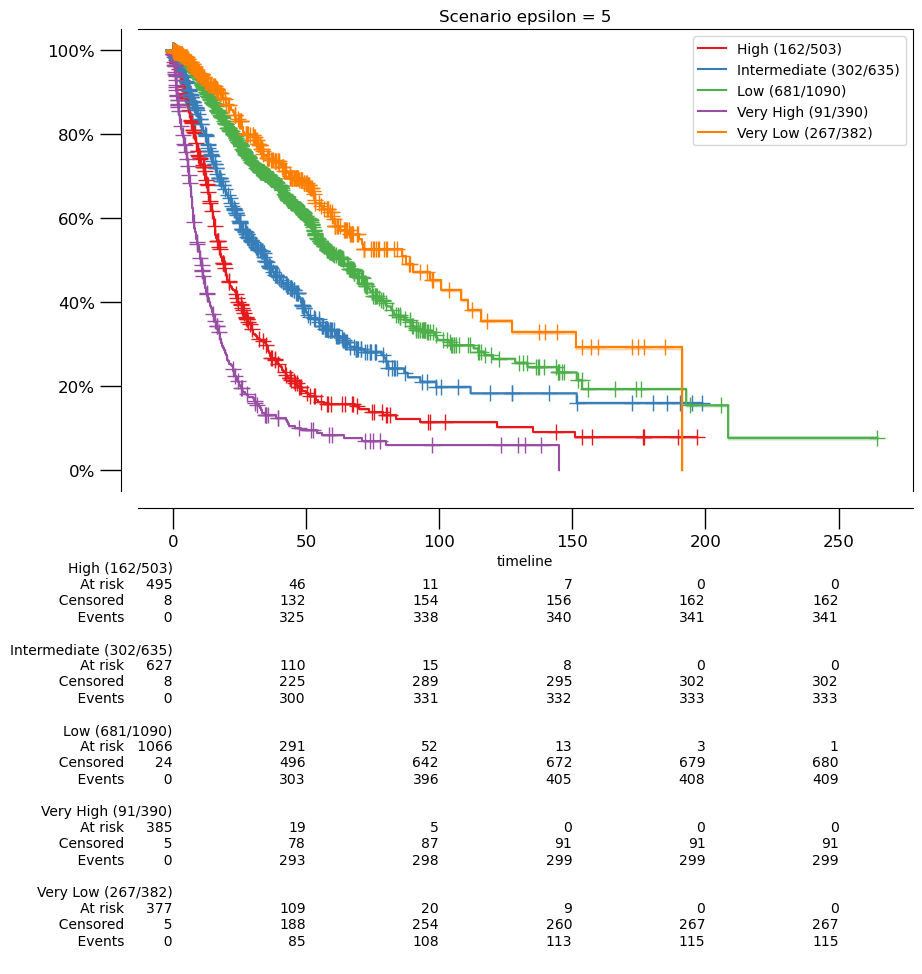

In [27]:
# Import example data
df_km = pd.DataFrame(columns=['time', 'Died', 'group'])

df_km['group'] = risk_IPSSR_dp
df_km['time'] = df_IPSSR_dp['Time (months)']
df_km['Died'] = df_IPSSR_dp['Status']

#remove rows with NaN values as time or status
df_km = df_km.dropna()

# Data
time_dp_event = df_km['time']
censoring_dp = df_km['Died']
y_dp = df_km['group']

print(df_km)


# Compute Survival
results = km.fit(time_dp_event, censoring_dp, y_dp)

# Plot
km.plot(results, title='Scenario epsilon = 5', y_percentage=True, width=10, height=6)